# Data Aggregation

## Importing Essential Libraries

In [54]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rasterio as rio
import geopy.distance
import math
from PIL import Image
import cv2

## Loading Data

In [115]:
maize_data_path = "../data/raw/yield_maize.tif"
soybean_data_path = "../data/raw/yield_soybean.tif"
defor_img_path = "../data/raw/10S60W.tif"

# Loading maize data
with rio.open(maize_data_path) as maize_src:
    maize_data = maize_src.read()
maize_data = np.squeeze(maize_data)

# Loading deforestation data
with rio.open(defor_img_path) as defor_src:
    defor_data = defor_src.read()
defor_data = np.squeeze(defor_data)

## Defining Data Segmentation Functions

In [3]:
def get_lat_long(data, src):
    # index array
    lat_index = np.arange(0, data.shape[0])
    long_index = np.arange(0, data.shape[1])
    
    # meshgrid
    long_grid, lat_grid = np.meshgrid(long_index, lat_index)
    
    # flattened grids
    lat_grid_flat = lat_grid.flatten()
    long_grid_flat = long_grid.flatten()
    
    # getting long and lat
    A = src.transform
    long, lat = rio.transform.xy(A, lat_grid_flat, long_grid_flat)
    
    # reshaping to shape of original data
    lat = np.array(lat).reshape(data.shape)
    long = np.array(long).reshape(data.shape)
    
    return lat, long

def segment_coords(data, lat, long, target_coords = (0, 0), border = 0, length = 10):
    # latitude/longitude variables
    lat_max = target_coords[0]
    lat_min = lat_max - length
    long_min = target_coords[1]
    long_max = long_min + length
    
    # length variables
    xlen = data.shape[1]
    ylen = data.shape[0]
    
    # find xmin and xmax
    xmin, xmax = None, None
    for x in range(xlen):
        if long[0, x] > long_min:
            xmin = x if xmin == None else xmin
        if long[0, xlen - x - 1] < long_max:
            xmax = xlen - x - 1 if xmax == None else xmax
            
    # find ymin and ymax
    ymin, ymax = None, None
    for y in range(ylen):
        if lat[ylen - y - 1, 0] > lat_min:
            ymin = ylen - y - 1 if ymin == None else ymin
        if lat[y, 0] < lat_max:
            ymax = y if ymax == None else ymax
            
    # index data from top-bottom, left-right
    return data[ymax:ymin + border, xmin:xmax + border]

## Segmenting Maize Data

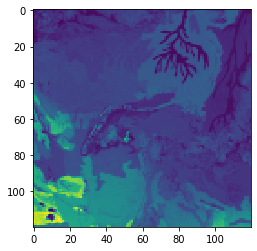

In [4]:
# Segmenting Maize Data 10S60W
target_coords = (-10, -60)
lat, long = get_lat_long(maize_data, maize_src)

maize_data_seg = segment_coords(maize_data, lat, long, target_coords, border = 1, length = 10)
plt.imshow(maize_data_seg)
plt.show()

## Defining Spatial Resolution Functions

## Computing 3km Grid

In [5]:
def get_dist(coords_1, coords_2):
    return geopy.distance.distance(coords_1, coords_2).km

def get_spatial_res(dist, arr):
    return (dist / arr.shape[0])

## Compute Spatial Resolution

In [6]:
dist = get_dist((-10, -60), (-10, -50))

defor_spatial_res = get_spatial_res(dist, defor_data)
print("Defor Spatial Resolution: {} km".format(defor_spatial_res))

maize_spatial_res = get_spatial_res(dist, maize_data_seg)
print("Maize Spatial Resolution: {} km".format(maize_spatial_res))

Defor Spatial Resolution: 0.027408788864225136 km
Maize Spatial Resolution: 9.136262954741712 km


In [7]:
# 10 South, 60 West
print("Top Border Distance: {} km".format(get_dist((-10, -60), (-10, -50))))
print("Right Border Distance: {} km".format(get_dist((-10, -50), (-20, -50))))
print("Bot Border Distance: {} km".format(get_dist((-20, -60), (-20, -50))))
print("Left Border Distance: {} km".format(get_dist((-20, -60), (-10, -60))))

Top Border Distance: 1096.3515545690054 km
Right Border Distance: 1106.511420937261 km
Bot Border Distance: 1046.3150761044421 km
Left Border Distance: 1106.511420937261 km


In [8]:
'''
Generates a grid where each cell represents the sum of a arr_spatial_res by cell_num_meter chunk of data.
Returns a tuple of sum grid, arr_spatial_res.
'''
def data_to_grid(arr, arr_spatial_res, grid_spatial_res = 3):
    # Initialize grid
    GRID_SIZE = math.ceil((arr.shape[0] * arr_spatial_res) / grid_spatial_res) + 1
    grid = np.zeros((GRID_SIZE, GRID_SIZE))
    # Generate grid
    for y in range(0, arr.shape[0]):
        for x in range(0, arr.shape[1]):
            # getting distance (in km) of top left corner of pixel from top left corner of entire data
            y_dist = y * arr_spatial_res
            x_dist = x * arr_spatial_res
            
            # getting indexes of grid
            grid_y = math.floor(y_dist / grid_spatial_res)
            grid_x = math.floor(x_dist / grid_spatial_res)
            
            # getting indexes of grid
            grid_y_dist = y // grid_spatial_res
            grid_x_dist = x // grid_spatial_res
            
            height_in, width_in, height_out, width_out = 0.0, 0.0, 0.0, 0.0
            
            if arr_spatial_res > grid_spatial_res:
                # compute height and width (in km) inside of grid
                height_in =  y_dist + arr_spatial_res - grid_y_dist + grid_spatial_res
                width_in =  x_dist + arr_spatial_res - grid_x_dist + grid_spatial_res
                
                # compute height and width (in km) outside of grid
                height_out = grid_spatial_res - height_in
                width_out = grid_spatial_res - width_in
            else:
                # compute height and width (in km) inside of grid
                height_in = grid_y_dist + grid_spatial_res - y_dist + arr_spatial_res
                width_in = grid_x_dist + grid_spatial_res - x_dist + arr_spatial_res
                
                # compute height and width (in km) outside of grid
                height_out = arr_spatial_res - height_in
                width_out = arr_spatial_res - width_in
                
            # update grid values
            grid[grid_y, grid_x] += width_in * height_in * arr[y, x]
            grid[grid_y + 1, grid_x] += width_in * height_out * arr[y, x]
            grid[grid_y, grid_x + 1] += width_out * height_in * arr[y, x]
            grid[grid_y + 1, grid_x + 1] += width_out * height_out * arr[y, x]
    return grid

In [9]:
def data_to_grid_smaller(arr, arr_spatial_res, grid_spatial_res = 3):
# Initialize grid
    spatial_ratio = arr_spatial_res / grid_spatial_res
    GRID_SIZE = math.ceil(arr.shape[0] * spatial_ratio)
    grid = np.zeros((GRID_SIZE, GRID_SIZE))
    # Generate grid
    for grid_y in range(0, GRID_SIZE):
        for grid_x in range(0, GRID_SIZE):
            # getting pixel indexes
            y = int(grid_y // spatial_ratio)
            x = int(grid_x // spatial_ratio)
            
            # getting distance (in km) of top left corner of pixel from top left corner of entire data
            y_dist = y * arr_spatial_res
            x_dist = x * arr_spatial_res
            
            # getting indexes of grid
            grid_y_dist = grid_y * grid_spatial_res
            grid_x_dist = grid_x * grid_spatial_res
            
            height_in, width_in, height_out, width_out = 0.0, 0.0, 0.0, 0.0
            
            # compute height and width (in km) inside of grid
            height_in = y_dist + arr_spatial_res - grid_y_dist
            height_in = arr_spatial_res if height_in < 0 else height_in
            width_in = x_dist + arr_spatial_res - grid_x_dist
            width_in = arr_spatial_res if width_in < 0 else width_in

            # compute height and width (in km) outside of grid
            height_out = arr_spatial_res - height_in
            width_out = arr_spatial_res - width_in
                
            # update grid values
            grid[grid_y, grid_x] += width_in * height_in * arr[y, x]
            if y + 1 < arr.shape[0]:
                grid[grid_y, grid_x] += width_in * height_out * arr[y + 1, x]
            if x + 1 < arr.shape[1]:
                grid[grid_y, grid_x] += width_out * height_in * arr[y, x + 1]
            if x + 1 < arr.shape[1] and y + 1 < arr.shape[0]:
                grid[grid_y, grid_x] += width_out * height_out * arr[y + 1, x + 1]
    return grid

In [10]:
def data_to_grid_smaller_updated(arr, arr_spatial_res, grid_spatial_res = 3):
# Initialize grid
    spatial_ratio = arr_spatial_res / grid_spatial_res
    GRID_SIZE = math.ceil((arr.shape[0] - 1) * spatial_ratio)
    grid = np.zeros((GRID_SIZE, GRID_SIZE))
    # Generate grid
    for grid_y in range(0, GRID_SIZE):
        for grid_x in range(0, GRID_SIZE):
            # getting pixel indexes
            y = int(grid_y // spatial_ratio)
            x = int(grid_x // spatial_ratio)
            
            # getting distance (in km) of top left corner of pixel from top left corner of entire data
            y_dist = y * arr_spatial_res
            x_dist = x * arr_spatial_res
            
            # getting indexes of grid
            grid_y_dist = grid_y * grid_spatial_res
            grid_x_dist = grid_x * grid_spatial_res
            
            height_in, width_in, height_out, width_out = 0.0, 0.0, 0.0, 0.0
            
            # compute height and width (in km) inside of grid
            height_in = min(y_dist + arr_spatial_res - grid_y_dist, grid_spatial_res)
            width_in = min(x_dist + arr_spatial_res - grid_x_dist, grid_spatial_res)

            # compute height and width (in km) outside of grid
            height_out = grid_spatial_res - height_in
            width_out = grid_spatial_res - width_in
                
            # update grid values
            grid[grid_y, grid_x] += (width_in * height_in * arr[y, x]) / (grid_spatial_res ** 2)
            if y + 1 < arr.shape[0]:
                grid[grid_y, grid_x] += (width_in * height_out * arr[y + 1, x]) / (grid_spatial_res ** 2)
            if x + 1 < arr.shape[1]:
                grid[grid_y, grid_x] += (width_out * height_in * arr[y, x + 1]) / (grid_spatial_res ** 2)
            if x + 1 < arr.shape[1] and y + 1 < arr.shape[0]:
                grid[grid_y, grid_x] += (width_out * height_out * arr[y + 1, x + 1]) / (grid_spatial_res ** 2)
    return grid

In [111]:
res = cv2.resize(maize_data_seg, dsize=(50, 50), interpolation = cv2.INTER_AREA)

In [112]:
# This is opencv resize
res[0,:20]

array([ 526,  807,  881,  945,  758,  855,  740,  987, 1251, 1005,  629,
        593,  396,  293,  564,  962, 1090, 1194, 1136, 1146], dtype=int16)

In [113]:
pillow_res = Image.fromarray(maize_data_seg)
pillow_res.thumbnail((50, 50))
pillow_res_array = np.array(pillow_res)
pillow_res_array[0,:20]

array([ 523,  800,  925,  952,  778,  823,  734, 1000, 1285, 1050,  615,
        540,  392,  234,  518,  936, 1109, 1194, 1141, 1142], dtype=int32)

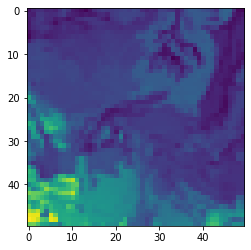

In [114]:
plt.imshow(pillow_res_array)
plt.show()

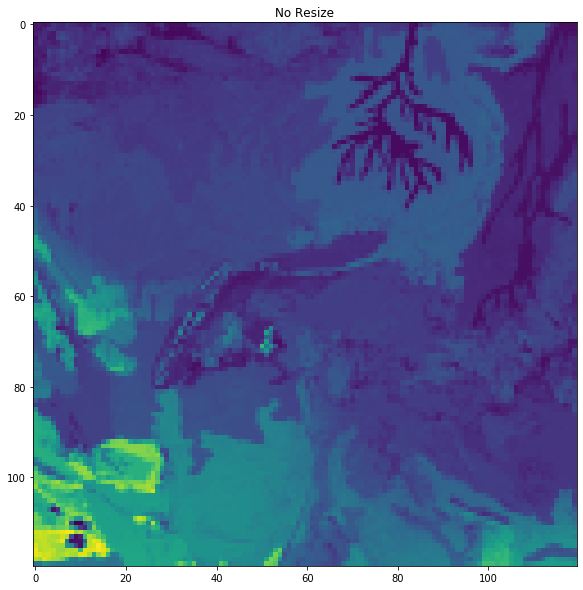

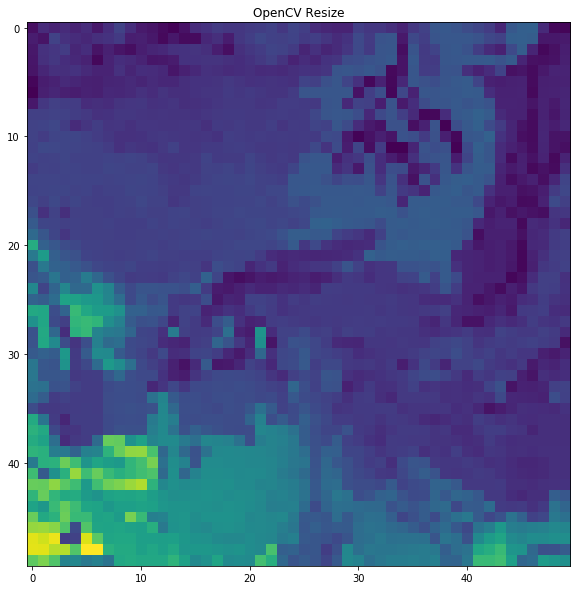

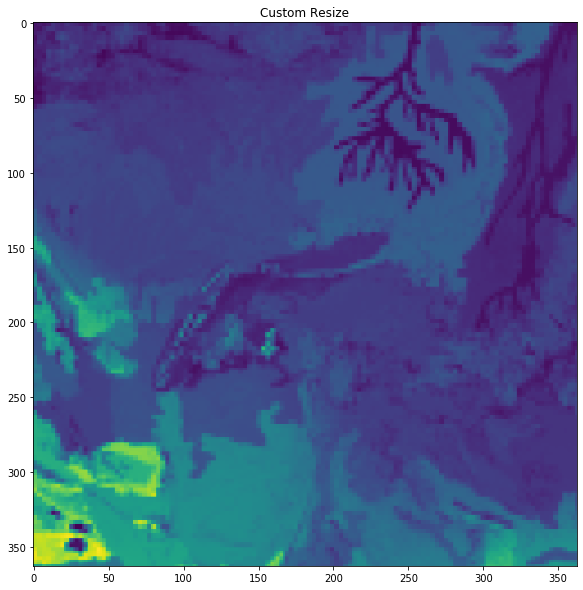

In [92]:
plt.figure(figsize = (10, 10))
plt.title("No Resize")
plt.imshow(maize_data_seg)
plt.savefig("../saved_figures/no_resize")

plt.figure(figsize = (10, 10))
plt.title("OpenCV Resize")
plt.imshow(res)
plt.savefig("../saved_figures/opencv_resize")

plt.figure(figsize = (10, 10))
plt.title("Custom Resize")
grid = data_to_grid_smaller_updated(maize_data_seg, maize_spatial_res)
plt.imshow(grid)
plt.savefig("../saved_figures/custom_resize")

In [86]:
# 0.2 degrees by 0.2 degrees per grid
# 500 x 500 grid size

In [87]:
# This is no resize
maize_data_seg[0,:20]

array([ 461,  535,  439,  592, 1037,  804,  710, 1037,  876,  769,  584,
        526,  611, 1091,  786,  883,  824,  808,  917, 1012], dtype=int16)

In [40]:
# This is the custom resize
grid[0,:20]

array([ 461.        ,  461.        ,  461.        ,  531.63884712,
        535.        ,  535.        ,  447.7208291 ,  439.        ,
        439.        ,  571.15176792,  592.        ,  592.        ,
        956.15064685, 1037.        , 1037.        ,  856.91544742,
        804.        ,  804.        ,  735.61743549,  710.        ])

In [39]:
maize_data_seg.shape

(120, 120)

In [68]:
res.shape

(50, 50)

In [104]:
maize_data_seg.shape

(120, 120)

In [30]:
grid.shape

(363, 363)

In [89]:
defor_res = cv2.resize(defor_data, dsize=(50, 50), interpolation = cv2.INTER_LINEAR)

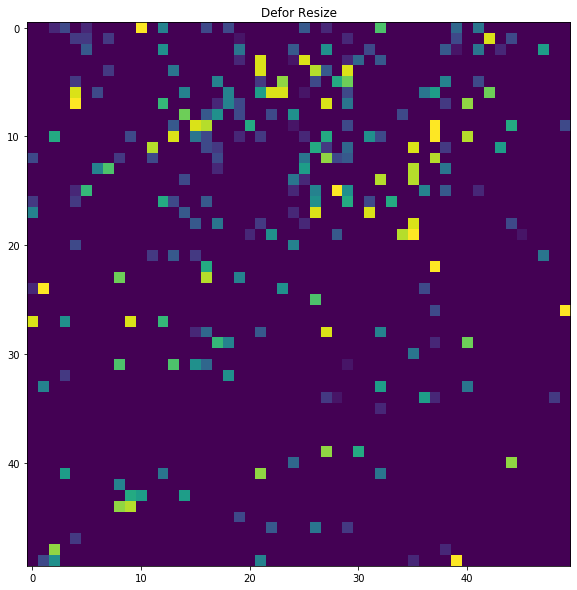

In [90]:
plt.figure(figsize = (10, 10))
plt.title("Defor Resize")
plt.imshow(defor_res)
plt.show()

In [57]:
output = Image.fromarray(maize_data_seg)
output.save("maize_data_segmentation.tif")

/usr/local/lib/python3.7/site-packages/rasterio/__init__.py:219: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


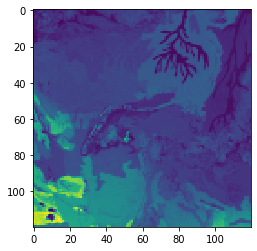

In [59]:
with rio.open("maize_data_segmentation.tif") as a:
    ab = a.read()
ab = np.squeeze(ab)
plt.imshow(ab)
plt.show()

In [70]:
a.transform

Affine(1.0, 0.0, 0.0,
       0.0, 1.0, 0.0)

In [72]:
maize_src.transform

Affine(0.08333333333333333, 0.0, -180.0,
       0.0, -0.08333333333333333, 90.0)